# Giới Thiệu Đề Tài: Phân loại Các Khóa Học Trên Udemy Dựa Vào Mô Tả

## Mô Tả Đề Tài

Dự án này nhằm mục đích xây dựng một hệ thống phân loại các khóa học trên Udemy dựa vào mô tả của chúng. Trên nền tảng dữ liệu thu thập từ trang web Udemy, chúng tôi sẽ áp dụng các kỹ thuật học máy để phân loại các khóa học vào các danh mục chính xác.

## Phương Pháp

1. **Thu thập Dữ liệu**: Sử dụng các công cụ web scraping để thu thập thông tin về các khóa học trên Udemy, bao gồm tiêu đề, mô tả và danh mục.

2. **Tiền xử lý Dữ liệu**: Kết hợp thông tin từ các trường 'Course_Title', 'Description' và 'Course_Content' thành một chuỗi duy nhất và thực hiện tiền xử lý dữ liệu để chuẩn bị cho quá trình phân loại.

3. **Vector hóa và Chuyển đổi Dữ liệu**: Sử dụng kỹ thuật vector hóa văn bản để biểu diễn dữ liệu dưới dạng các vectơ số và chuyển đổi ma trận đếm thành ma trận TF-IDF.

4. **Huấn luyện Mô hình**: Áp dụng mô hình học máy, chẳng hạn như Random Forest, để huấn luyện trên dữ liệu tiền xử lý.

5. **Đánh giá và Tối ưu Mô hình**: Đánh giá hiệu suất của mô hình bằng các độ đo như độ chính xác và sử dụng các kỹ thuật tối ưu hóa để cải thiện hiệu suất của mô hình.

6. **Triển Khai**: Triển khai mô hình đã huấn luyện vào một ứng dụng thực tế, cho phép người dùng phân loại các khóa học trên Udemy.

## Mục Tiêu

Mục tiêu cuối cùng của dự án là tạo ra một hệ thống phân loại linh hoạt và chính xác cho các khóa học trên Udemy, giúp người dùng dễ dàng tìm kiếm và tìm thấy các khóa học phù hợp với nhu cầu của họ.



IMPORT THƯ VIỆN 

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.datasets import load_files
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score,make_scorer

%matplotlib inline

A. TRÍCH XUẤT VECTO ĐẶC TRƯNG VÀ MÃ HOÁ DANH MỤC

In [2]:
# Đọc dữ liệu từ tệp CSV
train_data = pd.read_csv("./traindatanorm.csv")
print("Raw data shape: ", train_data.shape)
test_data = pd.read_csv("./testdatanorm.csv")
print("Raw data shape: ", test_data.shape)

Raw data shape:  (7809, 5)
Raw data shape:  (1959, 5)


1. Gộp các biến phụ thuộc thành 1 cột 

In [3]:
train_data['combined_features'] = train_data['Course_Title']+ ' ' + train_data['Description']+ ' ' + train_data['Course_Content']+ train_data['Lecturers_name']
test_data['combined_features'] = test_data['Course_Title']+ ' ' + test_data['Description']+ ' ' + test_data['Course_Content']+ test_data['Lecturers_name']

# Kiểm tra dữ liệu đã được kết hợp
print(train_data['combined_features'].head())
print(test_data['combined_features'].head())

0    complet javascript 2024 zero expert modern jav...
1    javascript weird part advanc javascript everyo...
2    javascript basic beginn javascript master fund...
3    modern javascript begin 2.0 2024 36 hour maste...
4    javascript beginn practic exercis javascript b...
Name: combined_features, dtype: object
0    full javascript es6 tutori includ es7 react de...
1    javascript web advanc web javascript javascrip...
2    javascript beginn javascript scratch javascrip...
3    javascript beginn javascript onlin supercharg ...
4    css javascript certif beginn add dynam client ...
Name: combined_features, dtype: object


2. Chia dữ liệu thành tập train và test

In [5]:


# Chia dữ liệu thành tập train và tập test
X_train, X_val, y_train, y_val = train_test_split(train_data['combined_features'],
                                                     train_data['Main_Category'], 
                                                     test_size=0.2, 
                                                     random_state=42)
X_test = test_data['combined_features']
y_test = test_data['Main_Category']

print(f"Test set size: {len(X_test)} samples")
print(f"Train set size: {len(X_train)} samples")
print(f"Val set size: {len(X_val)} samples")



Test set size: 1959 samples
Train set size: 6247 samples
Val set size: 1562 samples


3. Mã hoá danh mục

In [7]:

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_n = encoder.fit_transform(y_train)
y_val_n = encoder.fit_transform(y_val)
y_test_n = encoder.fit_transform(y_test)
target_name = encoder.classes_
print(target_name)

['business' 'design' 'development' 'finance & accounting'
 'health & fitness' 'it & software' 'lifestyle' 'marketing'
 'office productivity' 'personal development']


4. Trích xuất vecto đặc trưng TF-IDF 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_val_tfidf = tfidf_vect.transform(X_val)
X_test_tfidf = tfidf_vect.transform(X_test)


In [9]:
print("Vector hoá tập Train TF-IDF ",X_train_tfidf.data)
print("Kích thước vector ",X_train_tfidf.shape)
print("Vector hoá tập Test TF-IDF ",X_val_tfidf.data)
print("Kích thước vector ",X_val_tfidf.shape)

print("Vector hoá tập Test TF-IDF ",X_test_tfidf.data)
print("Kích thước vector ",X_test_tfidf.shape)


Vector hoá tập Train TF-IDF  [0.07409638 0.12885406 0.17903796 ... 0.20241388 0.192656   0.17442661]
Kích thước vector  (6247, 17595)
Vector hoá tập Test TF-IDF  [0.40147231 0.11511192 0.12956268 ... 0.14859591 0.14045293 0.21606304]
Kích thước vector  (1562, 17595)
Vector hoá tập Test TF-IDF  [0.30618774 0.09805251 0.06774777 ... 0.13680267 0.10450407 0.17350565]
Kích thước vector  (1959, 17595)


5. Giảm chiều dữ liệu SVD

In [10]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5400, random_state=42)
svd.fit(X_train_tfidf)

X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

print("Vector hoá tập Train SVD TF-IDF ",X_train_tfidf_svd.data)
print("Kích thước vector ",X_train_tfidf_svd.shape)
print("Vector hoá tập Val SVD TF-IDF ",X_val_tfidf_svd.data)
print("Kích thước vector ",X_val_tfidf_svd.shape)

print("Vector hoá tập Test SVD TF-IDF ",X_test_tfidf_svd.data)
print("Kích thước vector ",X_test_tfidf_svd.shape)

Vector hoá tập Train SVD TF-IDF  <memory at 0x000001EF4EF3AB50>
Kích thước vector  (6247, 5400)
Vector hoá tập Val SVD TF-IDF  <memory at 0x000001EF4EF3AB50>
Kích thước vector  (1562, 5400)
Vector hoá tập Test SVD TF-IDF  <memory at 0x000001EF4EF3AB50>
Kích thước vector  (1959, 5400)


B. ĐÁNH GIÁ VÀ HIỆU CHỈNH

1. ĐÁNH GIÁ

In [15]:


def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train_tfidf, y_train_n, cv=10, n_jobs=-1, 
                                                  train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

a. Đánh giá ảnh hưởng của độ đo trong Random Forest

100%|██████████| 2/2 [02:57<00:00, 88.87s/it]


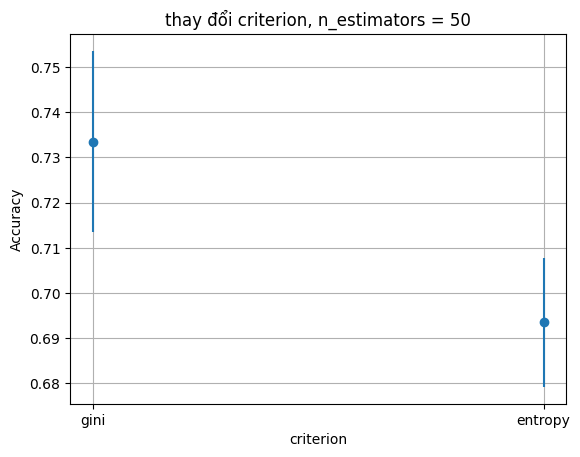

In [16]:
from tqdm import tqdm
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()


b. Đánh giá ảnh hưởng của số cây trong Random Forest 

100%|██████████| 4/4 [09:48<00:00, 147.03s/it]


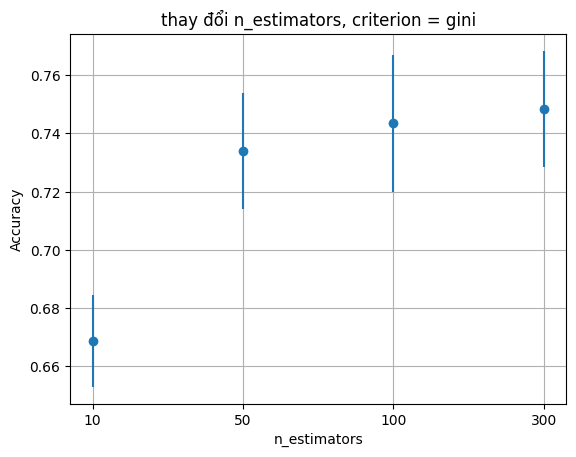

In [17]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()


2. Hiệu chỉnh và huấn luyện mô hình

In [18]:
rf_model_after = RandomForestClassifier(criterion='gini', n_estimators=300)
rf_model_after.fit(X_train_tfidf_svd, y_train_n)

RandomForestClassifier(n_estimators=300)

3. Kết quả sau khi huấn luyện

3.1 Kết quả hiệu chỉnh trên tập train 

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
train_predictions = rf_model_after.predict(X_train_tfidf_svd)
print("Accuracy on training set:", accuracy_score(y_train_n, train_predictions))
print("Classification report on training set:\n", classification_report(y_train_n, train_predictions, target_names=target_name))

Accuracy on training set: 0.9361293420842004
Classification report on training set:
                       precision    recall  f1-score   support

            business       0.85      0.85      0.85       611
              design       0.92      0.94      0.93       571
         development       0.90      0.92      0.91       587
finance & accounting       0.94      0.94      0.94       648
    health & fitness       1.00      1.00      1.00       666
       it & software       0.95      0.94      0.94       668
           lifestyle       0.99      0.99      0.99       649
           marketing       0.91      0.90      0.91       575
 office productivity       0.93      0.95      0.94       647
personal development       0.95      0.92      0.93       625

            accuracy                           0.94      6247
           macro avg       0.93      0.93      0.93      6247
        weighted avg       0.94      0.94      0.94      6247



3.2 Kết quả hiệu chỉnh trên tập validation:

In [21]:
val_predictions_after = rf_model_after.predict(X_val_tfidf_svd)
print("Accuracy on validate set:", accuracy_score(y_val_n, val_predictions_after))
print("Classification report on validate set:\n", classification_report(y_val_n, val_predictions_after ,target_names=target_name))


Accuracy on validate set: 0.7234314980793854
Classification report on validate set:
                       precision    recall  f1-score   support

            business       0.52      0.48      0.50       168
              design       0.70      0.78      0.74       139
         development       0.72      0.68      0.70       161
finance & accounting       0.80      0.77      0.78       151
    health & fitness       0.82      0.87      0.85       158
       it & software       0.79      0.76      0.78       156
           lifestyle       0.74      0.80      0.77       184
           marketing       0.73      0.69      0.71       150
 office productivity       0.79      0.82      0.80       139
personal development       0.62      0.59      0.60       156

            accuracy                           0.72      1562
           macro avg       0.72      0.73      0.72      1562
        weighted avg       0.72      0.72      0.72      1562



3.3 Kết quả hiệu chỉnh trên tập test:

In [22]:
# Đánh giá mô hình trên tập kiểm tra
test_predictions_after = rf_model_after.predict(X_test_tfidf_svd)
print("Accuracy on test set:", accuracy_score(y_test_n, test_predictions_after))
print("Classification report on test set:\n", classification_report(y_test_n, test_predictions_after ,target_names=target_name))

Accuracy on test set: 0.7401735579377233
Classification report on test set:
                       precision    recall  f1-score   support

            business       0.62      0.52      0.57       214
              design       0.78      0.75      0.77       191
         development       0.75      0.79      0.77       210
finance & accounting       0.73      0.81      0.77       176
    health & fitness       0.81      0.81      0.81       186
       it & software       0.84      0.78      0.81       224
           lifestyle       0.63      0.81      0.71       192
           marketing       0.79      0.71      0.75       185
 office productivity       0.77      0.88      0.82       169
personal development       0.69      0.58      0.63       212

            accuracy                           0.74      1959
           macro avg       0.74      0.75      0.74      1959
        weighted avg       0.74      0.74      0.74      1959



3.4 Biểu đồ Accuracy trên tập train, test, vallidation

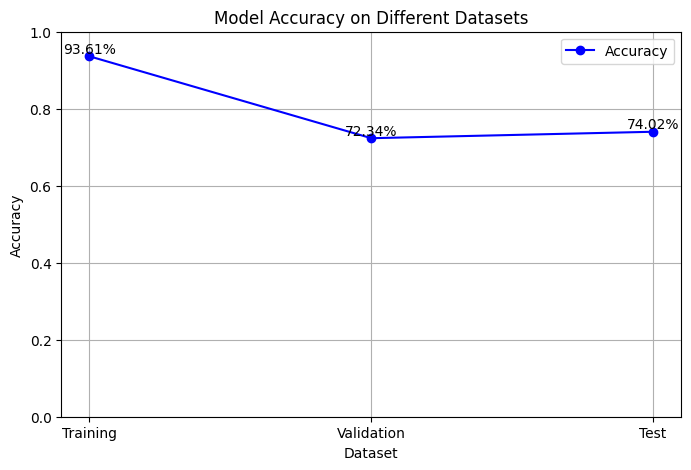

In [27]:
import matplotlib.pyplot as plt

# Độ đo Accuracy trên các tập dữ liệu
accuracies = [accuracy_score(y_train_n, train_predictions), accuracy_score(y_val_n, val_predictions_after), accuracy_score(y_test_n, test_predictions_after)]
datasets = ['Training', 'Validation', 'Test']

plt.figure(figsize=(8, 5))
plt.plot(datasets, accuracies, marker='o', color='b', label='Accuracy')
plt.title('Model Accuracy on Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Thêm chú thích về phần trăm trên từng điểm
for i in range(len(datasets)):
    plt.text(datasets[i], accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', va='bottom')

plt.show()


In [26]:
from sklearn.metrics import classification_report

# Bảng số liệu trên tập Kiểm thử
print("Classification report on test set:\n", classification_report(y_test_n, test_predictions_after, target_names=target_name))


Classification report on test set:
                       precision    recall  f1-score   support

            business       0.62      0.52      0.57       214
              design       0.78      0.75      0.77       191
         development       0.75      0.79      0.77       210
finance & accounting       0.73      0.81      0.77       176
    health & fitness       0.81      0.81      0.81       186
       it & software       0.84      0.78      0.81       224
           lifestyle       0.63      0.81      0.71       192
           marketing       0.79      0.71      0.75       185
 office productivity       0.77      0.88      0.82       169
personal development       0.69      0.58      0.63       212

            accuracy                           0.74      1959
           macro avg       0.74      0.75      0.74      1959
        weighted avg       0.74      0.74      0.74      1959



3.4 Giá trị Accuracy, Precision, Recall, F1-score trên tập train, test , validation

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Huấn luyện
train_predictions = rf_model_after.predict(X_train_tfidf_svd)
# Xác thực
val_predictions_after = rf_model_after.predict(X_val_tfidf_svd)
# Kiểm tra
test_predictions_after = rf_model_after.predict(X_test_tfidf_svd)

# Tính các độ đo
metrics = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [
        accuracy_score(y_train_n, train_predictions),
        accuracy_score(y_val_n, val_predictions_after),
        accuracy_score(y_test_n, test_predictions_after)
    ],
    'Precision': [
        precision_score(y_train_n, train_predictions, average='macro'),
        precision_score(y_val_n, val_predictions_after, average='macro'),
        precision_score(y_test_n, test_predictions_after, average='macro')
    ],
    'Recall': [
        recall_score(y_train_n, train_predictions, average='macro'),
        recall_score(y_val_n, val_predictions_after, average='macro'),
        recall_score(y_test_n, test_predictions_after, average='macro')
    ],
    'F1 Score': [
        f1_score(y_train_n, train_predictions, average='macro'),
        f1_score(y_val_n, val_predictions_after, average='macro'),
        f1_score(y_test_n, test_predictions_after, average='macro')
    ]
}

import pandas as pd

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


      Dataset  Accuracy  Precision    Recall  F1 Score
0       Train  0.936129   0.934887  0.934896  0.934837
1  Validation  0.723431   0.722977  0.725437  0.723499
2        Test  0.740174   0.742172  0.745529  0.741003


In [23]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix SVM')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

In [29]:
print(metrics_df.to_markdown())


|    | Dataset    |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-----------|-----------:|------------:|---------:|-----------:|
|  0 | Train      |   0.936129 |    0.934887 | 0.934896 |   0.934837 |
|  1 | Validation |   0.723431 |    0.722977 | 0.725437 |   0.723499 |
|  2 | Test       |   0.740174 |    0.742172 | 0.745529 |   0.741003 |


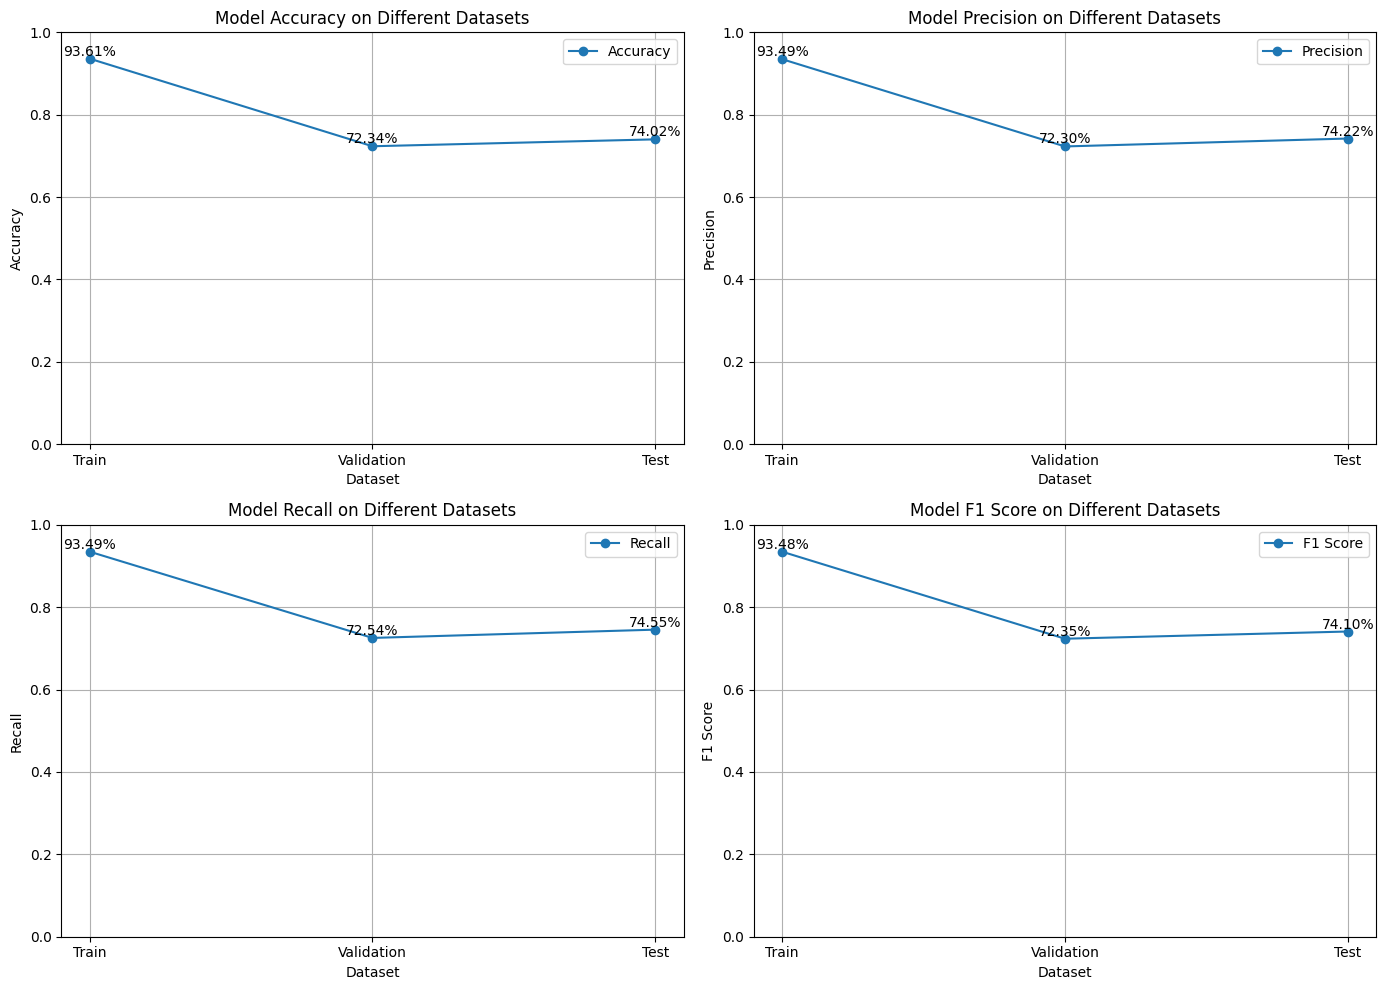

In [30]:
import matplotlib.pyplot as plt

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ax = ax.ravel()

for idx, metric in enumerate(metrics_names):
    ax[idx].plot(metrics['Dataset'], metrics[metric], marker='o', label=metric)
    ax[idx].set_title(f'Model {metric} on Different Datasets')
    ax[idx].set_xlabel('Dataset')
    ax[idx].set_ylabel(metric)
    ax[idx].set_ylim(0, 1)
    ax[idx].legend()
    ax[idx].grid(True)
    
    # Thêm chú thích về phần trăm trên từng điểm
    for i in range(len(metrics['Dataset'])):
        ax[idx].text(metrics['Dataset'][i], metrics[metric][i], f'{metrics[metric][i]*100:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Ma trận nhầm lẫn khi phân loại trên tập test

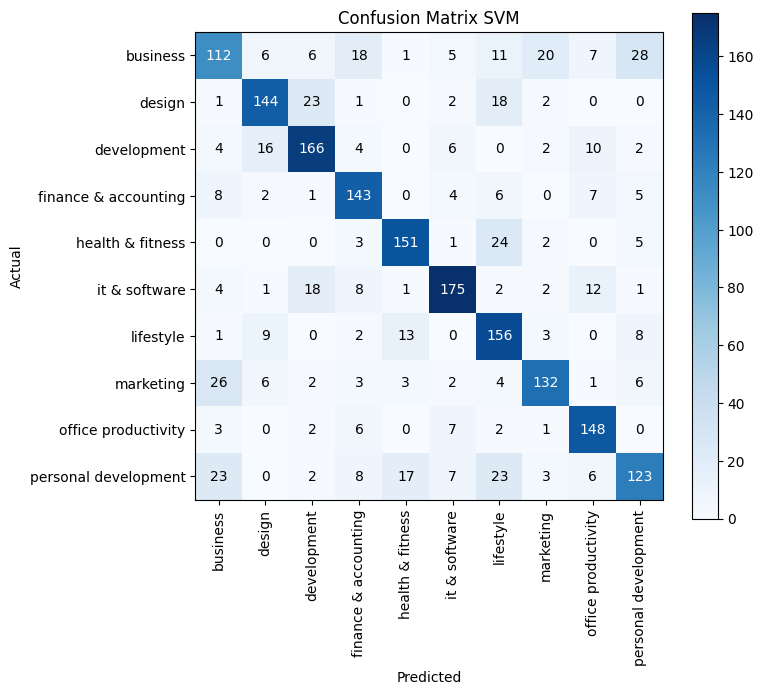

In [24]:
plot_confusion_matrix(y_test_n, test_predictions_after, target_name)

KẾT LUẬN:
- Cả hai mô hình SVM và Random Forest đều đạt hiệu suất cao trong việc phân loại khóa học, với độ chính xác trên 70%.
- Lựa chọn mô hình : 
    + Khi cần độ chính xác cao trong phân loại, SVM là lựa chọn tốt hơn.
    + Nếu ưu tiên triển khai nhanh chóng Random Forest có thể là lựa chọn phù hợp
- Cải thiện: cần phân tích thêm các chỉ số khác như độ tin cậy, độ nhạy, độ F1-score, v.v. để đánh giá toàn diện hiệu quả của từng mô hình.
Hạn chế:   dữ liệu vẫn còn bị mất cân bằng và nhiễu
